# XGBoost Model

In [59]:
# Custom Functions
from Credit_Func import *

# Import the Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Other
import pickle

# Model
from xgboost import XGBClassifier

# Sklearn
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

In [263]:
fpr

134

In [267]:
def plot_confusion_matix(y_val, y_pred, classes, model_name=None):
    import itertools
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print('\n clasification report:\n', classification_report(y_val,y_pred))
    print("-----------------------------------------------")
#     print(f"Accuracy: {round(accuracy*100,3)}%")
#     print(f"Precision: {round(precision*100,3)}%")
#     print(f"Recall: {round(recall*100,3)}%")
#     print(f"f1_score: {round(f1*100,3)}%")

    cnf_matrix = confusion_matrix(y_val, y_pred)
    fpr = int(cnf_matrix[0][1] + cnf_matrix[1][1])
    print(f"Frauds: {y_val.sum()} | Missed: {round((cnf_matrix[1][0]/y_val.sum())*100,1)}%")
    print(f"Total Flagged: {fpr} | Real: {round((cnf_matrix[1][0]/fpr)*100,1)}%")
    
    # Create the basic matrix
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

    # Add title and axis labels
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    class_names = ['',classes[0],'',classes[1],'']# set(y) # Get class labels to add to matrix
    tick_marks = [-0.5,0,0.5,1,1.5]
    
    # Add appropriate axis scales
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')

In [17]:
df = pd.read_csv('creditcard.csv')

In [18]:
time = df['Time']
new_time = []
for d in time:
    if d <= 86400:     # There are 86400 seconds in a day
        new_time.append(d)
    else:
        new_time.append(d - 86400)
        
df['Time'] = new_time      

In [19]:
y = df.Class

X = df.drop(columns=['Class'], axis=1)

# TTS

In [20]:
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Data Shapes:")
print(f"X_tv: {X_tv.shape} | X_test: {X_test.shape} | y_tv {y_tv.shape} | y_test {y_test.shape}")
print(f"Number of Frauds in TV: {y_tv.sum()} | {round((y_tv.sum() / y_tv.shape[0])*100, 5)}%")
print(f"Number of Frauds in Test: {y_test.sum()} | {round((y_test.sum() / y_test.shape[0])*100, 5)}%")

Data Shapes:
X_tv: (199364, 30) | X_test: (85443, 30) | y_tv (199364,) | y_test (85443,)
Number of Frauds in TV: 356 | 0.17857%
Number of Frauds in Test: 136 | 0.15917%


In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.3, random_state=42)

print(f"X_train: {X_train.shape} | X_val: {X_val.shape} | y_train {y_train.shape} | y_val {y_val.shape}")
print(f"Number of Frauds in Train: {y_train.sum()} | {round((y_train.sum() / y_train.shape[0])*100, 5)}%")
print(f"Number of Frauds in Validation: {y_val.sum()} | {round((y_val.sum() / y_val.shape[0])*100, 5)}%")

X_train: (139554, 30) | X_val: (59810, 30) | y_train (139554,) | y_val (59810,)
Number of Frauds in Train: 258 | 0.18487%
Number of Frauds in Validation: 98 | 0.16385%


# Scaling

In [22]:
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_Val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
trans = [X_train_transformed, X_Val_transformed, X_test_transformed]

for X in trans:
    print(("mean: "), np.round(X.mean(), 2))
    print(("standard dev: "), np.round(X.std(), 2))

mean:  0.0
standard dev:  1.0
mean:  -0.0
standard dev:  1.0
mean:  0.0
standard dev:  0.99


In [23]:
# Reset data
X_train = X_train_transformed
X_val = X_Val_transformed
X_test = X_test_transformed

# Sampling

In [26]:
from imblearn.over_sampling import SMOTE, ADASYN

## SMOTE

In [27]:
# Previous original class distribution
print("original class distribution:")
print(y_train.value_counts())

# Fit SMOTE to training data
smote = SMOTE(sampling_strategy='auto') # resample all classes but the majority class
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print("SMOTE_even class distribution")
print(pd.Series(y_train_smote).value_counts()) 

original class distribution:
0    139296
1       258
Name: Class, dtype: int64


SMOTE_even class distribution
1    139296
0    139296
Name: Class, dtype: int64


## ADASYN

In [28]:
# Previous original class distribution
print("original class distribution:")
print(y_train.value_counts())

# Fit SMOTE to training data
adasyn = ADASYN(sampling_strategy='auto') # resample all classes but the majority class
X_train_adasyn, y_train_adasyn = adasyn.fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print("ADASYN class distribution")
print(pd.Series(y_train_adasyn).value_counts()) 

original class distribution:
0    139296
1       258
Name: Class, dtype: int64


ADASYN class distribution
1    139323
0    139296
Name: Class, dtype: int64


# XGBoost Model

In [30]:
param_grid_xg_final = {
    'learning_rate': [0.4],
    'max_depth': [4],
    'min_child_weight': [4],
    'subsample': [0.9],
    'n_estimators': [100],
}

In [32]:
gs_xg = GridSearchCV(estimator=XGBClassifier(random_state=123),
            param_grid=param_grid_xg_final,
            scoring='roc_auc',
            cv=5, verbose=1, return_train_score = True,  n_jobs=1)

gs_xg.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=123, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.4], 'max_depth': [4],
                         'min_child_weight': [4], 'n_estimators': [100],
 

In [33]:
from joblib import dump, load
dump(gs_xg, 'xgboost_model_final.joblib') 

['xgboost_model_final.joblib']

In [34]:
opt_xg = GS_Output_DataFrame(gs_xg)
opt_xg.sort_values(by='mean_test_score', ascending=False)

,learning_rate,max_depth,min_child_weight,n_estimators,subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.4,4,4,100,0.9,0.99999,0.000017,1.0,5.112021e-07


In [35]:
best_model = gs_xg.best_estimator_
print(gs_xg.best_params_)

{'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}


In [50]:
y_pred = best_model.predict(X_val)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
y_prob = best_model.predict_proba(X_val)
y_prob

array([[9.9912333e-01, 8.7664794e-04],
       [1.0000000e+00, 5.3829696e-09],
       [9.9999517e-01, 4.8051425e-06],
       ...,
       [9.9985373e-01, 1.4627178e-04],
       [9.9999833e-01, 1.6551601e-06],
       [9.9891382e-01, 1.0861632e-03]], dtype=float32)


 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59712
           1       0.61      0.84      0.71        98

    accuracy                           1.00     59810
   macro avg       0.81      0.92      0.85     59810
weighted avg       1.00      1.00      1.00     59810

-----------------------------------------------
Frauds: 98 | Missed: 16.3%
Total Flagged: 134 | Real: 11.9%


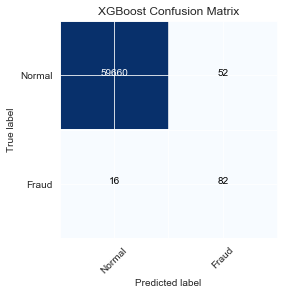

In [268]:
plot_confusion_matix(y_val, y_pred, ['Normal', "Fraud"], "XGBoost")

In [100]:
def roc_plot(model,X_train_smote,y_train_smote,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

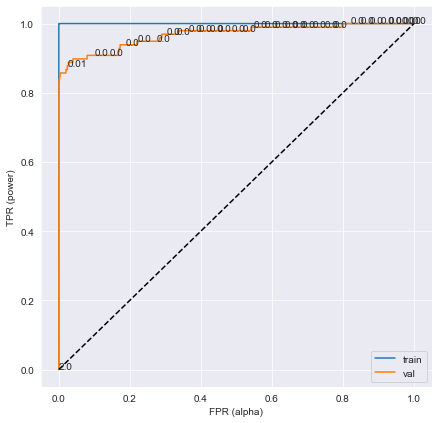

In [101]:
roc_plot(best_model, X_train,y_train,X_val,y_val)

## Feature Importance

In [97]:
features = pd.DataFrame(best_model.feature_importances_, index=[X_tv.columns], columns=['Importance'])
features = features.loc[features['Importance'] != 0]
# features

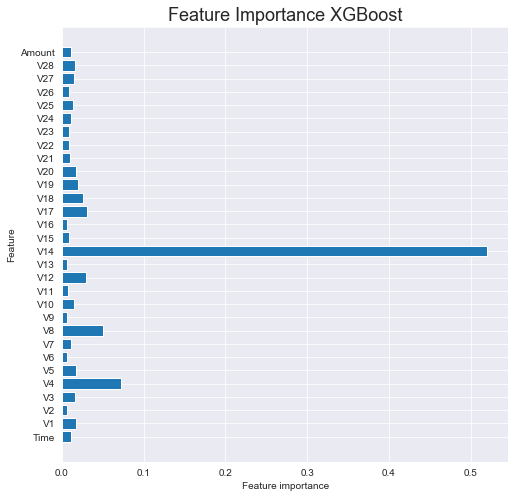

In [99]:
def plot_feature_importances(model, X):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance XGBoost', fontsize=18)

plot_feature_importances(best_model, X_tv)

## Threshold Selection

In [64]:
cnf_matrix = confusion_matrix(y_val, y_pred)
cnf_matrix

array([[59660,    52],
       [   16,    82]])

In [70]:
prevalence = df['Class'].sum()/df.shape[0]
fraud_cost_coef = 122.21132113821139
normal_cost_coef = 88.29102242231328

In [230]:
def threshold_selection_mark(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y, y_hat):
    """Calculate the optimal treshold depending on prevalence, costs, true positive rate and false positive rate
    Args:
        prevalence (float): The percentage of positives in the population
        CostFP_minus_CostTN (float): [description]
        CostFN_minus_CostTP (float): [description]
        y (list): True labels (classes)
        y_hat (list): Predicted labels (classes)
    Returns:
        [float]: Best threshold
    """
    fpr, tpr, thresholds = roc_curve(y, y_hat)
    m = ((1 - prevalence) / prevalence) * ((CostFP_minus_CostTN) / (CostFN_minus_CostTP))
    fm_thresholds = []
    for i in range(len(fpr)):
        fm = tpr[i] - (m * fpr[i])
        fm_thresholds.append((thresholds[i], fm, fpr[i], tpr[i]))
#     fm_thresholds_df = pd.DataFrame(data=fm_thresholds, columns=['Threshold', 'fm', 'FPR', 'TPR'])
#     fm_thresholds_df.sort_values(by='fm', inplace=True, ascending=False)
    fm_thresholds = sorted(fm_thresholds, key=lambda fm_value: fm_value[1], reverse=True)
#     return fm_thresholds_df
    return fm_thresholds[0][0]

In [238]:
threshold_opt = threshold_selection_mark(prevalence, fraud_cost_coef, normal_cost_coef, y_val, y_prob[:,1])
threshold_opt

0.9960233

In [190]:
threshold_select_df = threshold_selection_mark(prevalence, fraud_cost_coef, normal_cost_coef, y_val, y_prob[:,1])
threshold_select_df.head()

,Threshold,fm,FPR,TPR
14,0.996023,0.714915,0.000050,0.755102
10,0.998756,0.711094,0.000017,0.724490
12,0.998571,0.707902,0.000033,0.734694
11,0.998657,0.697698,0.000033,0.724490
13,0.996626,0.694507,0.000050,0.734694


In [223]:
threshold_select_df['Threshold'].mean()

0.018193069294245384

In [250]:
y_prob_adj = y_prob[:,1]

y_prob_adj_new = []
for y in y_prob_adj: 
    if y <= (1-0.99):
        y=0
        y_prob_adj_new.append(y)
    else:
        y=1
        y_prob_adj_new.append(y)


In [251]:
confusion_matrix(y_val, y_prob_adj_new)

array([[58565,  1147],
       [   14,    84]])


 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     59712
           1       0.07      0.86      0.13        98

    accuracy                           0.98     59810
   macro avg       0.53      0.92      0.56     59810
weighted avg       1.00      0.98      0.99     59810

-----------------------------------------------
Frauds: 98 | Missed: 14.3%
Total Flagged: 1231 | Real: 1.1%


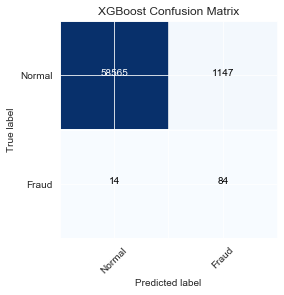

In [269]:
plot_confusion_matix(y_val, y_prob_adj_new, ['Normal', "Fraud"], "XGBoost")

In [245]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the Threshold", fontsize=16)
    plt.plot(thresholds, precisions, "b--", label="Precision")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')

In [214]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_val, y_prob[:,1])

In [215]:
thresholds.shape

(47160,)

In [216]:
r.shape

(47161,)

In [217]:
p = list(p[:-1])
r = list(r[:-1])

In [218]:
thresholds = list(thresholds)

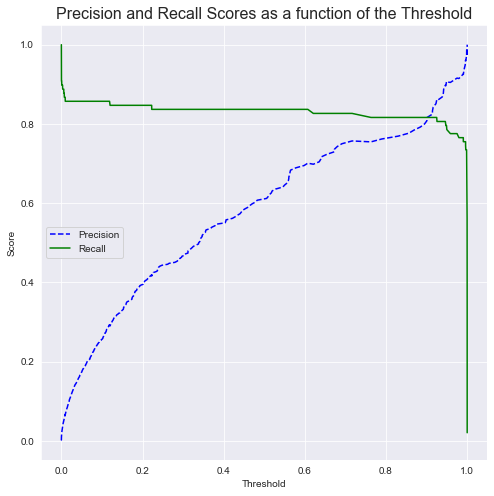

In [246]:
plot_precision_recall_vs_threshold(p, r, thresholds)